<a href="https://colab.research.google.com/github/malborroni/RECMojion/blob/master/Architecture_selection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Confronto Architetture

Script in cui vengono confrontati i valori di accuarcy sulle diverse architetture considerate

# Librerie

In [0]:
# Example of face detection with a vggface2 model
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import pandas as pd
import random as rnd

import seaborn as sns
from matplotlib import style
style.use('seaborn-pastel')

import keras
from keras.layers import Dense, Dropout, Flatten, Activation, Conv2D, MaxPooling2D
from keras.models import Model, Sequential, load_model
from keras.utils import to_categorical
from keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from keras import regularizers
from keras.callbacks import EarlyStopping, ModelCheckpoint 
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import os
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split,StratifiedKFold

import random
import pickle

Using TensorFlow backend.


In [0]:
# fix random seed for reproducibility
seed = 42
np.random.seed(seed)

# Funzioni

In [0]:
def graph(history):
  # funzione che prende in input il modello fittato e fa un plot della loss in validation e train
  epochs=len(history.history['loss'])
  x_plot = list(range(1,epochs+1))
  plt.figure()
  
  plt.subplot(1, 2, 1)
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.plot(x_plot, history.history['loss'])
  plt.plot(x_plot, history.history['val_loss'])
  plt.legend(['Training', 'Validation'])

  
  plt.subplot(1, 2, 2)
  plt.xlabel('Epochs')
  plt.ylabel('Acc')
  plt.plot(x_plot, history.history['acc'])
  plt.plot(x_plot, history.history['val_acc'])
  plt.legend(['Training', 'Validation'])
  
  plt.tight_layout()
  plt.show()


#Dataset

Il dataset si trova in un file chiamato data_prep.npz nel drive 




In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
data = np.load('/content/drive/My Drive/AML/extracted_3fold1.npz')

# training set
x_train1 = data['x_train1']
y_train1 = data['y_train1']

# validation set
x_val1 = data['x_val1']
y_val1 = data['y_val1']

# test set
x_test1 = data['x_test1']
y_test1 = data['y_test1']

In [0]:
data = np.load('/content/drive/My Drive/AML/extracted_3fold2.npz')

# training set
x_train2 = data['x_train2']
y_train2 = data['y_train2']

# validation set
x_val2 = data['x_val2']
y_val2 = data['y_val2']

# test set
x_test2 = data['x_test2']
y_test2 = data['y_test2']

In [0]:
data = np.load('/content/drive/My Drive/AML/extracted_3fold3.npz')

# training set
x_train3 = data['x_train3']
y_train3 = data['y_train3']

# validation set
x_val3 = data['x_val3']
y_val3 = data['y_val3']

# test set
x_test3 = data['x_test3']
y_test3 = data['y_test3']

Codifica dei labels

In [0]:
le = LabelEncoder()
def y_encoder(y_train,y_val,y_test):
    y_train = le.fit_transform(y_train)
    y_train = to_categorical(y_train, num_classes = 7)
    y_test = le.fit_transform(y_test)
    y_test = to_categorical(y_test, num_classes = 7)
    y_val = le.fit_transform(y_val)
    y_val = to_categorical(y_val, num_classes = 7)
    return y_train,y_val,y_test

In [0]:
y_train1,y_val1,y_test1=y_encoder(y_train1,y_val1,y_test1)
y_train2,y_val2,y_test2=y_encoder(y_train2,y_val2,y_test2)
y_train3,y_val3,y_test3=y_encoder(y_train3,y_val3,y_test3)

# Modello

In [0]:
from keras import regularizers
def create_model(C=1,D=1):
'''
Funzione che prende in input il livello di profondità per il blocco convoluzionale "C" e per il blocco denso "D"
e restituisce il modello già compilato
'''
  # Create model
  model = Sequential()
# C
  # C1
  model.add(Conv2D(32, kernel_size=1, activation='relu', input_shape=(14, 14, 1024)))
  model.add(Conv2D(128, kernel_size=3, activation='relu'))
  model.add(Conv2D(32, kernel_size=1, activation='relu'))
  # C2
  if(C>1):
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(32, kernel_size=1, activation='relu'))
  # C3
  if(C>2):
    model.add(Conv2D(32, kernel_size=3, activation='relu'))
    model.add(Conv2D(32, kernel_size=1, activation='relu'))

  model.add(Flatten())
# D
  # D1
  model.add(Dense(21, activation='relu',kernel_regularizer=regularizers.l2(0.01))) 
  model.add(Dropout(0.5))
  # D2
  if(D>1):
    model.add(Dense(56, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
    model.add(Dropout(0.3))
  # D3
  if(D>2):
    model.add(Dense(112, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
    model.add(Dropout(0.3))
  
  model.add(Dense(7, activation='softmax'))

  # Compile model
  model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['acc'])
  return model

In [0]:
# check
model=create_model()
model.summary()

# 3-Fold

In [0]:
def nn_fit_eval(acc_scores,loss_scores,x_train,y_train,x_val,y_val,x_test,y_test):
    '''
    Funzione che prende in input train.validation e test set per fare il training  e la
    valutazione della rete. In più prende in input acc_scores e loss_scores che sono le performance 
    su eventuali precedenti fold in vista di una cross validation.
    Restituisce gli array con gli scores aggiornati.
    '''
    # Fit the model
    model_log = model.fit(x_train, y_train,
        batch_size=batch_size,
        epochs=num_epoch,
        verbose=0,
        validation_data=(x_val, y_val),
        callbacks=callbacks_list)
    
    # visualize graph
    graph(model_log)

    # Evaluate the model
    scores = model.evaluate(x_test, y_test, verbose=1)
    accuracy = 100*scores[1]
    loss = scores[0]
    print("Post-training accuracy: {} %".format(round(accuracy, 3)))
    print("Post-training loss: {}".format(round(loss, 4)))
    acc_scores.append(accuracy)
    loss_scores.append(loss)
    return acc_scores,loss_scores


In [0]:
# config model
batch_size = 128
num_epoch = 60
# callbacks
filepath = "/content/drive/My Drive/AML/Model/pre_optimization.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
early_stop = EarlyStopping(monitor='val_loss', patience=30, verbose=1,restore_best_weights=False) 
callbacks_list = [early_stop, checkpoint]

Cross validation che cicla sui modelli

In [0]:
result = {}
for c in range(1,4):
    for d in range(1,4):
        model_name="C"+str(c)+"-"+"D"+str(d)
        print(model_name)
    # create model
        model = create_model(c,d)
    

    # Fit and validate the model
        acc_scores= []
        loss_scores = []

        # Fold1
        acc_scores,loss_scores=nn_fit_eval(acc_scores,loss_scores,x_train1,y_train1,x_val1,y_val1,x_test1,y_test1)
        model = create_model(c,d)
        # Fold2
        acc_scores,loss_scores=nn_fit_eval(acc_scores,loss_scores,x_train2,y_train2,x_val2,y_val2,x_test2,y_test2)
        model = create_model(c,d)
        # Fold3
        acc_scores,loss_scores=nn_fit_eval(acc_scores,loss_scores,x_train3,y_train3,x_val3,y_val3,x_test3,y_test3)

    # Mean evaluation   
        print("mean accuracy: {}% (sd: +/- {}%)".format(round(np.mean(acc_scores), 2), round(np.std(acc_scores), 2)))
        print("mean loss: {}  (sd: +/- {} )".format(np.mean(loss_scores), np.std(loss_scores)))
        # Saving results in the dictionary "result"
        result[model_name] = (np.mean(acc_scores), np.std(acc_scores), np.mean(loss_scores), np.std(loss_scores))
    

C1-D1


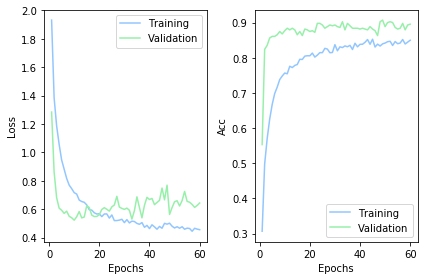

864/864 [==============================] - 0s 479us/step
Post-training accuracy: 90.278 %
Post-training loss: 0.5335


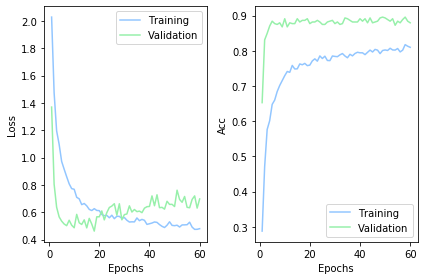

863/863 [==============================] - 0s 472us/step
Post-training accuracy: 91.078 %
Post-training loss: 0.5681
Restoring model weights from the end of the best epoch
Epoch 00040: early stopping


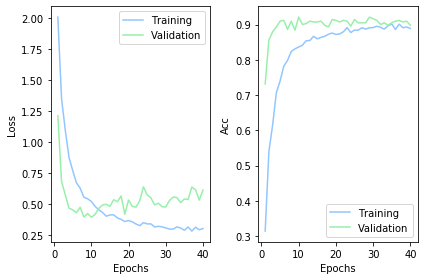

863/863 [==============================] - 0s 466us/step
Post-training accuracy: 89.803 %
Post-training loss: 0.4831
mean accuracy: 90.39% (sd: +/- 0.53%)
mean loss: 0.5282341608005677  (sd: +/- 0.034934539911965566 )
C1-D2


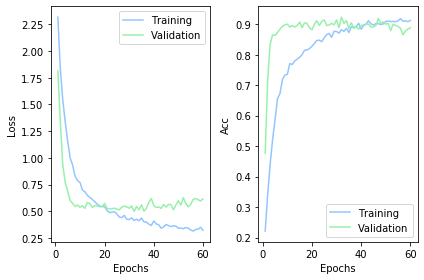

864/864 [==============================] - 0s 475us/step
Post-training accuracy: 89.931 %
Post-training loss: 0.6261
Restoring model weights from the end of the best epoch
Epoch 00057: early stopping


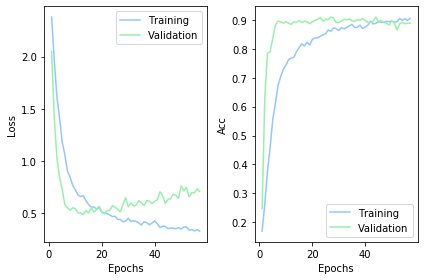

863/863 [==============================] - 0s 472us/step
Post-training accuracy: 90.035 %
Post-training loss: 0.4885


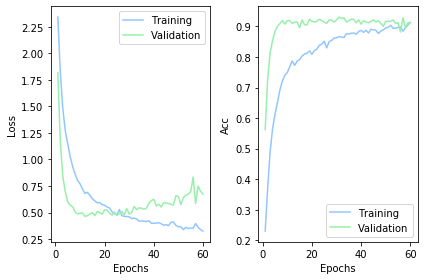

863/863 [==============================] - 0s 482us/step
Post-training accuracy: 89.803 %
Post-training loss: 0.7298
mean accuracy: 89.92% (sd: +/- 0.09%)
mean loss: 0.6147919664139939  (sd: +/- 0.09882377059186086 )
C1-D3


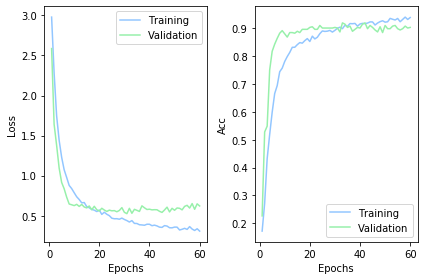

864/864 [==============================] - 0s 490us/step
Post-training accuracy: 90.741 %
Post-training loss: 0.6708


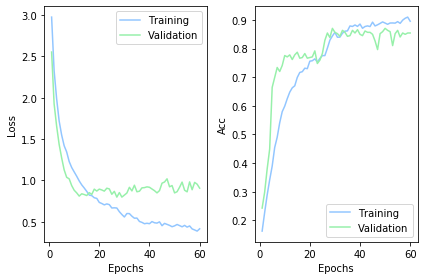

863/863 [==============================] - 0s 478us/step
Post-training accuracy: 85.052 %
Post-training loss: 0.802


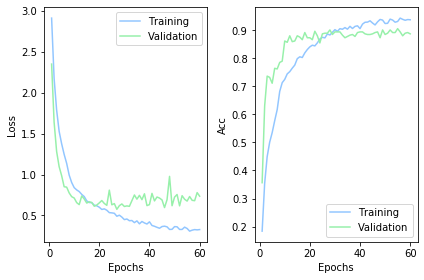

863/863 [==============================] - 0s 475us/step
Post-training accuracy: 88.528 %
Post-training loss: 0.8148
mean accuracy: 88.11% (sd: +/- 2.34%)
mean loss: 0.7625532542524255  (sd: +/- 0.06505580879353168 )
C2-D1


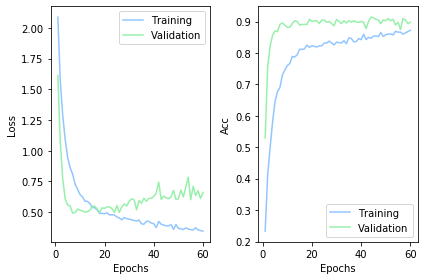

864/864 [==============================] - 0s 477us/step
Post-training accuracy: 90.046 %
Post-training loss: 0.6811


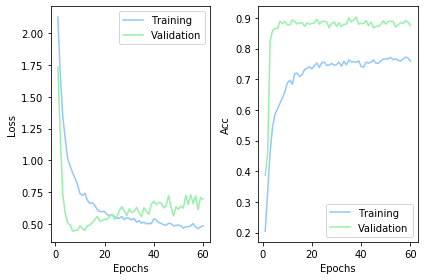

863/863 [==============================] - 0s 475us/step
Post-training accuracy: 89.34 %
Post-training loss: 0.6273
Restoring model weights from the end of the best epoch
Epoch 00046: early stopping


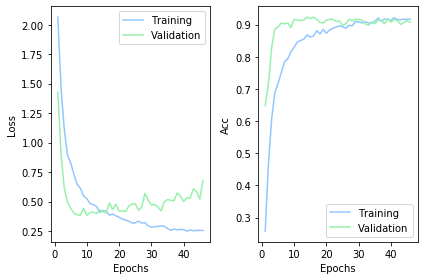

863/863 [==============================] - 0s 499us/step
Post-training accuracy: 89.803 %
Post-training loss: 0.537
mean accuracy: 89.73% (sd: +/- 0.29%)
mean loss: 0.6151623603291155  (sd: +/- 0.05945056427799028 )
C2-D2


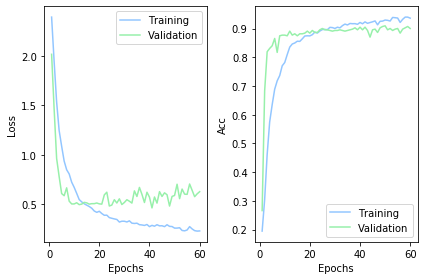

864/864 [==============================] - 0s 477us/step
Post-training accuracy: 91.319 %
Post-training loss: 0.6276
Restoring model weights from the end of the best epoch
Epoch 00042: early stopping


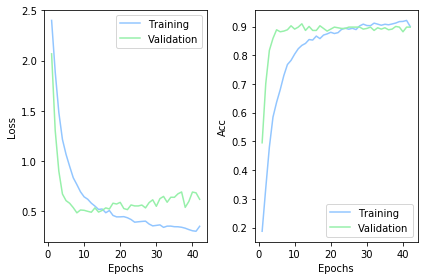

863/863 [==============================] - 0s 499us/step
Post-training accuracy: 90.267 %
Post-training loss: 0.4371
Restoring model weights from the end of the best epoch
Epoch 00051: early stopping


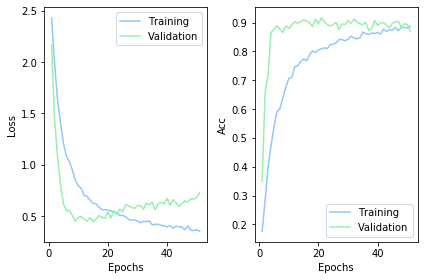

863/863 [==============================] - 0s 518us/step
Post-training accuracy: 89.455 %
Post-training loss: 0.575
mean accuracy: 90.35% (sd: +/- 0.76%)
mean loss: 0.5465519515179279  (sd: +/- 0.08033008994233617 )
C2-D3
Restoring model weights from the end of the best epoch
Epoch 00054: early stopping


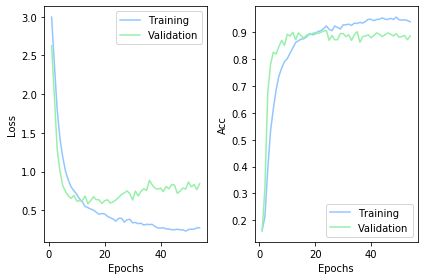

864/864 [==============================] - 0s 525us/step
Post-training accuracy: 90.162 %
Post-training loss: 0.6137
Restoring model weights from the end of the best epoch
Epoch 00047: early stopping


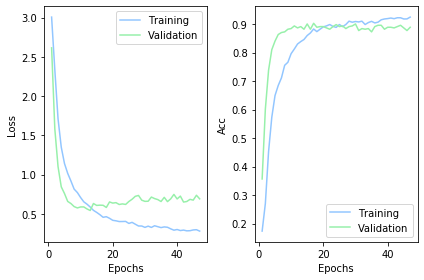

863/863 [==============================] - 0s 542us/step
Post-training accuracy: 89.34 %
Post-training loss: 0.6355


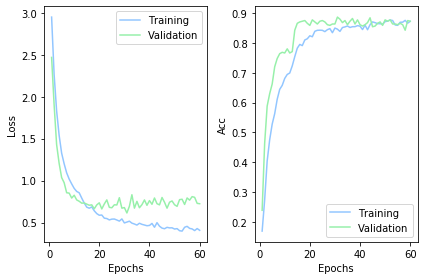

863/863 [==============================] - 0s 540us/step
Post-training accuracy: 86.674 %
Post-training loss: 0.9325
mean accuracy: 88.73% (sd: +/- 1.49%)
mean loss: 0.7272689124356422  (sd: +/- 0.14540699009147184 )
C3-D1
Restoring model weights from the end of the best epoch
Epoch 00059: early stopping


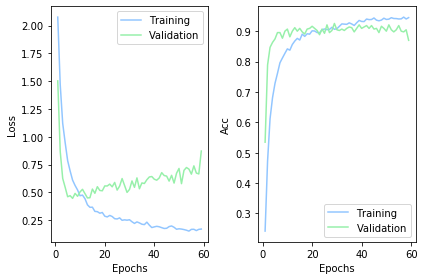

864/864 [==============================] - 0s 525us/step
Post-training accuracy: 89.583 %
Post-training loss: 0.7124
Restoring model weights from the end of the best epoch
Epoch 00046: early stopping


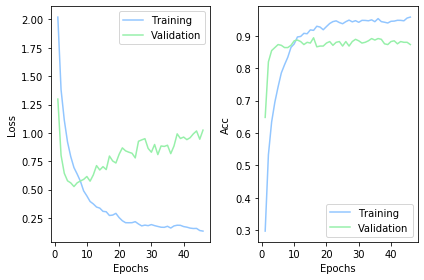

863/863 [==============================] - 0s 523us/step
Post-training accuracy: 91.889 %
Post-training loss: 0.5449


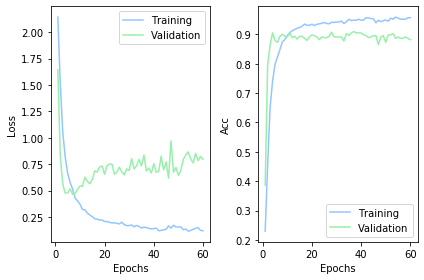

863/863 [==============================] - 0s 525us/step
Post-training accuracy: 88.644 %
Post-training loss: 0.9559
mean accuracy: 90.04% (sd: +/- 1.36%)
mean loss: 0.7377275766666068  (sd: +/- 0.1687214508618791 )
C3-D2


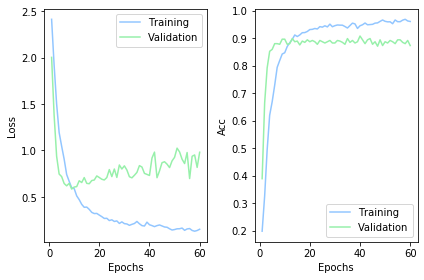

864/864 [==============================] - 0s 523us/step
Post-training accuracy: 89.815 %
Post-training loss: 0.7328


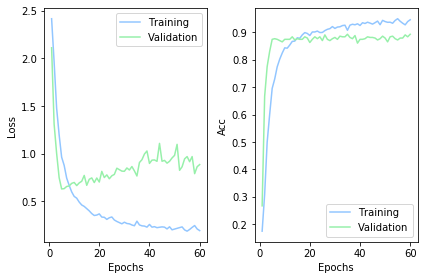

863/863 [==============================] - 0s 523us/step
Post-training accuracy: 90.614 %
Post-training loss: 0.708
Restoring model weights from the end of the best epoch
Epoch 00057: early stopping


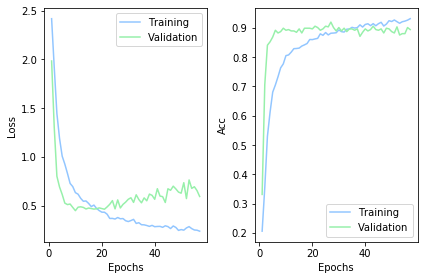

863/863 [==============================] - 0s 538us/step
Post-training accuracy: 89.108 %
Post-training loss: 0.701
mean accuracy: 89.85% (sd: +/- 0.62%)
mean loss: 0.7139065444514004  (sd: +/- 0.013639498084328823 )
C3-D3
Restoring model weights from the end of the best epoch
Epoch 00044: early stopping


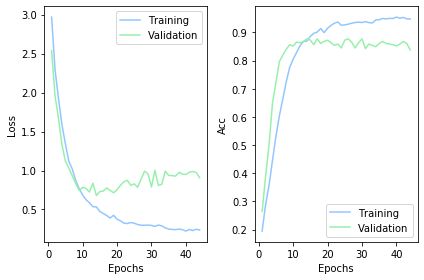

864/864 [==============================] - 0s 484us/step
Post-training accuracy: 87.5 %
Post-training loss: 0.605


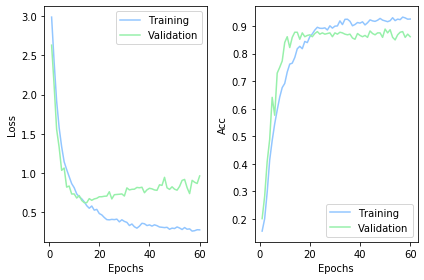

863/863 [==============================] - 0s 504us/step
Post-training accuracy: 87.486 %
Post-training loss: 0.7934


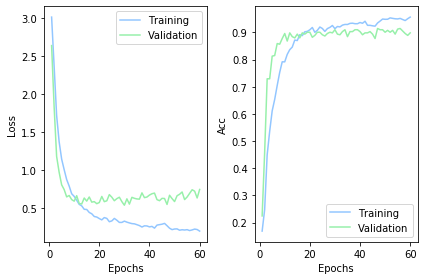

863/863 [==============================] - 0s 511us/step
Post-training accuracy: 88.76 %
Post-training loss: 0.8929
mean accuracy: 87.92% (sd: +/- 0.6%)
mean loss: 0.7637646000127742  (sd: +/- 0.11938126664118018 )


In [0]:
result = {}
for c in range(1,4):
    for d in range(1,4):
        model_name="C"+str(c)+"-"+"D"+str(d)
        print(model_name)
    # create model
        model = create_model(c,d)
    

    # Fit and validate the model
        acc_scores= []
        loss_scores = []

        # Fold1
        acc_scores,loss_scores=nn_fit_eval(acc_scores,loss_scores,x_train1,y_train1,x_val1,y_val1,x_test1,y_test1)
        model = create_model(c,d)
        # Fold2
        acc_scores,loss_scores=nn_fit_eval(acc_scores,loss_scores,x_train2,y_train2,x_val2,y_val2,x_test2,y_test2)
        model = create_model(c,d)
        # Fold3
        acc_scores,loss_scores=nn_fit_eval(acc_scores,loss_scores,x_train3,y_train3,x_val3,y_val3,x_test3,y_test3)

    # Mean evaluation   
        print("mean accuracy: {}% (sd: +/- {}%)".format(round(np.mean(acc_scores), 2), round(np.std(acc_scores), 2)))
        print("mean loss: {}  (sd: +/- {} )".format(np.mean(loss_scores), np.std(loss_scores)))
        # Saving results in the dictionary "result"
        result[model_name] = (np.mean(acc_scores), np.std(acc_scores), np.mean(loss_scores), np.std(loss_scores))
        


# Persist

In [0]:
import json

with open('/content/drive/My Drive/AML/result_3fold.json', 'w') as fp:
    json.dump(result, fp)
